In [7]:
import numpy as np
import pandas as pd
import os, sys, glob, shutil 
from config import *
from plotting_functions import *
import analysis_helpers as helper

sys.path.insert(0,'../..')
%load_ext autoreload
%autoreload 2
%matplotlib inline
# from MRAE.dataHandler import TestDataset
from scipy.ndimage import zoom
# import preprocessing.prepare_day1_model as prep
# from MRAE.mrae import ManifoldRegularizedAutoencoder
# from MRAE import dataHandler
from sklearn.linear_model import LinearRegression
from TPHATE.tphate import tphate
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import inspect
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.stats import zscore, wasserstein_distance, ttest_1samp, ttest_rel, ttest_ind, sem,f_oneway, spearmanr, pearsonr
from sklearn.decomposition import PCA
import matplotlib as mpl
import scprep
import nibabel as nib
from nilearn.maskers import NiftiMasker
from nilearn import plotting,image  
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["pdf.use14corefonts"] = True
sns.set_context(context_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


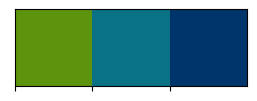

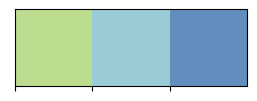

In [7]:
colors_main = {'OMP': '#5C940D', 'WMP': '#0B7285', 'IM': '#00356b'}
pal = sns.palplot(colors_main.values())

colors_sim = {'OMP': '#BCDC8F', 'WMP': '#9ACCD5', 'IM': '#618EBC'}
pal = sns.palplot(colors_sim.values())

# TPHATE scatterplots

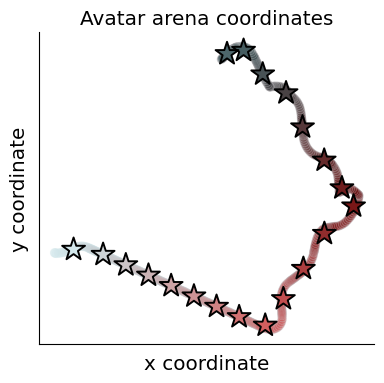

In [8]:
#scatterplot of matching arena coordinates

C0 = [256,256,256]
C1 = [255,0,0] # pink
C2 = [154, 204, 213] # teal
C3 = [0,0,0]
pos = helper.get_position_file('avatarRT_sub_09', "ses_01", 3, 1) # one trial
xz = zscore(pos['x'].values)
zz = zscore(pos['z'].values)
cmap=transform_values_to_2d_colormap(xz,zz, C0, C1, C2, C3, cmap_resolution=100, plot=False)
fig,ax=plt.subplots(1,1,figsize=(4,4))
g=sns.scatterplot(y=xz[::10], x=zz[::10], s=40, c=[rgb2range(c) for c in cmap][::10], alpha=0.4, 
                  lw=2, ax=ax, edgecolor=[rgb2range(c) for c in cmap])
g.set(xlabel='x coordinate',ylabel='y coordinate',title='Avatar arena coordinates')
xn=average_groups(xz,20)
zn=average_groups(zz,20)
cmap=transform_values_to_2d_colormap(xn,zn, C0, C1, C2, C3, cmap_resolution=100, plot=False)
g=sns.scatterplot(y=xn,x=zn,s=300, c=[rgb2range(c) for c in cmap],alpha=1,marker='*',ax=ax,edgecolor='k',lw=0.05)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
plt.tight_layout()
sns.despine()
plt.savefig('./plots/schematics/coordinates_game.pdf', transparent=True,bbox_inches = "tight") #

loading /gpfs/milgram/scratch60/turk-browne/elb77/rtoffline//joystick_analyses/avatarRT_sub_09_run_03_bold_preproc_v2_native_navigation_mask.npy of shape (302, 1427)
loading /gpfs/milgram/scratch60/turk-browne/elb77/rtoffline//avatarRT_sub_09_embedding_3d.npy


[[],
 [],
 Text(429.31313131313124, 0.5, 'TRs'),
 Text(0.5, -1.277777777777784, 'TRs'),
 Text(0.5, 1.0, 'Distance in T-PHATE space')]

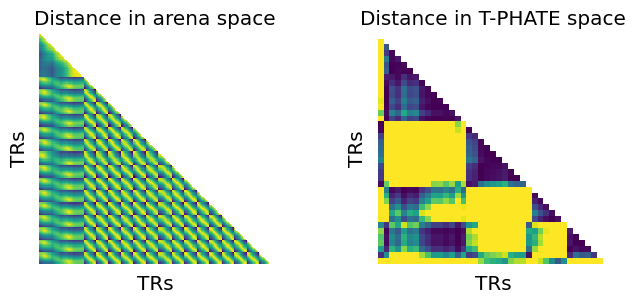

In [22]:
# heatmap for matching coordinates

S='avatarRT_sub_09'
ds, tr, x, z = helper.load_all_joystick_data(S,3,None)
fn=f'{SCRATCH_PATH}/{S}_embedding_3d.npy'
if os.path.exists(fn):
    tph_embd=np.load(fn)[:len(ds)]
    print(f'loading {fn}')
else: 
    tph=tphate.TPHATE(n_components=3, t=7,verbose=0)
    tph_embd = tph.fit_transform(ds)
    print('embedding')
    np.save(f'{SCRATCH_PATH}/{S}_embedding_3d.npy',tph_embd)

T=tph_embd[tr>=0]#[:200]
X=x[:len(ds)][tr>=0]
Z=z[:len(ds)][tr>=0]
flattened_tr = helper.flatten_trials(tr[tr>=0])

M = 1-squareform(pdist(np.array((X,Z)).T))

M1=T[flattened_tr==1]
M1 = squareform(pdist(M1, metric='correlation'))

fig,axes=plt.subplots(1,2,figsize=(8,3))

mask = np.triu(np.ones_like(M, dtype=bool))
g=sns.heatmap(M, cmap='viridis',square=True, mask=mask, cbar=False,ax=axes[0])
g.set(xticks=[],yticks=[],ylabel='TRs',xlabel='TRs',title='Distance in arena space')

mask = np.triu(np.ones_like(M1, dtype=bool))

g=sns.heatmap(M1, cmap='viridis',vmax=1, mask=mask, square=True,cbar=False,ax=axes[1])
g.set(xticks=[],yticks=[],ylabel='TRs',xlabel='TRs',title='Distance in T-PHATE space')
#plt.savefig('plots/distance_mat_tphate.pdf')

# joystick decoding & rsa

err_lin_loto Ttest_relResult(statistic=10.515706681447806, pvalue=2.327220194514914e-09)
0.00019998000199980003
mantel_z Ttest_relResult(statistic=-3.6616109617821944, pvalue=0.0016586810966077727)
0.0007999200079992001


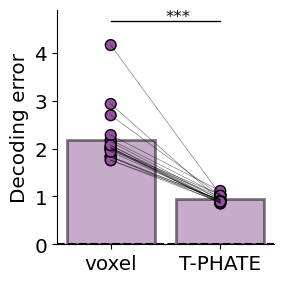

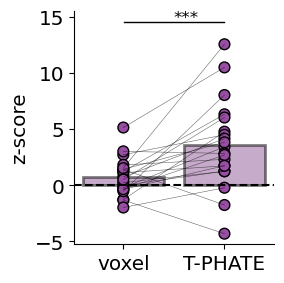

In [9]:
joy_df = pd.read_csv('./results/joystick_decoding_himalaya.csv',index_col=0)
joy_df = joy_df[['embedding','mantel_z','err_lin_loto','subject_id']]

ynames = ['err_lin_loto', 'mantel_z']
titles = [ '', '']
ylabels = [ 'Decoding error', 'z-score']
pal = [sns.color_palette('Set1',6)[3] for i in [1,-1]]
#pal = ['w']*2
yplus = [0.5,2]
for i in range(2):
    fig,ax=plt.subplots(1,1, figsize=(3,3))
    g=sns.barplot(x='embedding', y=ynames[i], data=joy_df, palette=pal,ax=ax, alpha=0.5, edgecolor='k',linewidth=2,errorbar=None)
    ax.axhline(0, ls='--', c='k') 
    points0,points1=[],[]
    #g=sns.stripplot(x='embedding', y=ynames[i], data=res, palette='inferno', ax=ax, alpha=1, linewidth=1)
    for sub in joy_df.subject_id.unique():
        p0 = joy_df[(joy_df['subject_id']==sub)&(joy_df['embedding']==0)][ynames[i]].item()
        p1 = joy_df[(joy_df['subject_id']==sub)&(joy_df['embedding']==1)][ynames[i]].item()
        points0.append(p0)
        points1.append(p1)
        ax.scatter([0,1],[p0,p1],linewidth=1,s=60,edgecolors='k', c=[pal[0], pal[1]])
        ax.plot([0,1],[p0,p1],color='k',alpha=0.6, linewidth=0.4)
        
    g.set(title=titles[i], xticklabels=['voxel','T-PHATE'], ylabel=ylabels[i], xlabel='')
    ttest_results =ttest_rel(points0,points1) 
    p=ttest_results[1]
    print(ynames[i], ttest_results)
    
    _,pv,_=helper.permutation_test(np.array([points0,points1]),n_iterations=10000,alternative='two-sided')
    print(pv)
    if pv > 0.5: pv=1-pv
    pstr = determine_symbol(pv)
    yloc = np.max(np.concatenate((points0,points1)))+yplus[i]
    
    if pstr!=None:
        ax.axhline(xmin=0+0.25, xmax=1-0.25, y=yloc, color='k', lw=1)
        ax.text(x=0.5, y=yloc+0.0004, s=pstr)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'plots/joystick_{ynames[i]}.pdf', transparent=True, bbox_inches='tight')
    

In [27]:
df_runchange=pd.read_csv('./results/final_results/runwise_component_EVR_neural_analysis_run_change.csv')
cong_df = df_runchange[df_runchange['congruent']==True].reset_index(drop=True)
make_barplot_points(cong_df, 
                    'delta_run_perturb', 
                    'session_type', 
                    exclude_subs=[12,9,20], ylim=[-0.045, .07],
                    outfn='plots/data/neural_EVR_within_session.pdf',
                    plus_bot=0.01, plus_top=0.02, n_iter=10000, sample_alternative='greater',
                    pairwise_alternative='greater', title='')

['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.0044, WM 0.045, OM 0.8242
IMvWM: 0.2529, IMvOM: 0.0054, WMvOM: 0.0356


In [29]:
df_runchange.columns

Index(['Unnamed: 0', 'session_type', 'session_number', 'nfb_component_idx',
       'congruent', 'comparison_component_idx', 'delta_run_perturb',
       'comparison_component_name', 'subject_id'],
      dtype='object')

In [33]:
df_runchange=pd.read_csv('./results/final_results/runwise_component_EVR_neural_analysis_run_change.csv')
for M in ORDER:
    evr_df = df_runchange[df_runchange['session_type']==M].reset_index(drop=True)
    make_barplot_points(evr_df, 
                        'delta_run_perturb', 
                        'comparison_component_name', 
                        exclude_subs=[12,9,20], ylim=[-0.1, .1],
                        outfn=f'plots/data/neural_EVR_across_comp_{M}.pdf',
                        plus_bot=0.01, plus_top=0.02, n_iter=10000, sample_alternative='greater',
                        pairwise_alternative='greater', title='')

['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.0044, WM 0.2615, OM 0.4817
IMvWM: 0.0522, IMvOM: 0.1239, WMvOM: 0.3945
['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.8041, WM 0.045, OM 0.9389
IMvWM: 0.9893, IMvOM: 0.1657, WMvOM: 0.0107
['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_

In [35]:
behav = pd.read_csv(BEHAV_SESSION_RES)


In [36]:
behav.head()

,Unnamed: 0,delta_error,delta_BC,session_type,session_number,subject_id
0,0,0.071514,0.40,IM,2,avatarRT_sub_05
1,1,0.275097,0.56,WMP,3,avatarRT_sub_05
2,2,0.194617,-0.24,OMP,4,avatarRT_sub_05
3,3,0.235621,0.36,IM,2,avatarRT_sub_06
4,4,0.068705,0.20,WMP,4,avatarRT_sub_06


In [40]:
behav = pd.read_csv(BEHAV_SESSION_RES)
new_df = pd.DataFrame(columns=['session_type','session_number','delta_EVR','delta_BC','subject_id'])
for s in SUB_IDS:
    if s in ['avatarRT_sub_09','avatarRT_sub_20']: continue
    temp = cong_df[cong_df['subject_id']==s]
    temp1 = behav[behav['subject_id']==s]
    for M in ORDER:
        v0=temp[temp['session_type']==M]
        v1=temp1[temp1['session_type']==M]
        new_df.loc[len(new_df)] = {'session_type':M, 'session_number':v1.session_number.item(), 
                                  'delta_EVR':v0.delta_run_perturb.item(), 'delta_BC':v1.delta_BC.item(),
                                  'subject_id':s} 
        


In [41]:
new_df

,session_type,session_number,delta_EVR,delta_BC,subject_id
0,IM,2,0.035580,0.40,avatarRT_sub_05
1,WMP,3,0.050398,0.56,avatarRT_sub_05
2,OMP,4,0.004348,-0.24,avatarRT_sub_05
3,IM,2,-0.005052,0.36,avatarRT_sub_06
4,WMP,4,-0.009034,0.20,avatarRT_sub_06
5,OMP,3,0.007410,-0.16,avatarRT_sub_06
6,IM,2,0.015314,0.56,avatarRT_sub_07
7,WMP,3,-0.007159,0.20,avatarRT_sub_07
8,OMP,4,-0.001659,0.04,avatarRT_sub_07
9,IM,2,-0.000197,0.60,avatarRT_sub_08
